In [2]:
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.python.keras import Input

from sklearn import metrics
from csv import writer

import utils

c:\Users\User\anaconda3\envs\nerf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\User\anaconda3\envs\nerf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you wan

#### Data Preprocessing

In [3]:
# radar_dataset = DataControl('./data/')
radar_dataset = utils.DataControl('./data/')

# Training Set
x_train = radar_dataset.x_train
y_train = radar_dataset.y_train
seq_len_train = radar_dataset.seq_len_train

# Testing Set
x_test = radar_dataset.x_test
y_test = radar_dataset.y_test
seq_len_test = radar_dataset.seq_len_test

print('Training Set:', x_train.shape, y_train.shape, seq_len_train.shape)
print('Testing Shape', x_test.shape, y_test.shape, seq_len_test.shape)

Training Set: (29, 717, 5) (29, 717) (29,)
Testing Shape (3, 717, 5) (3, 717) (3,)


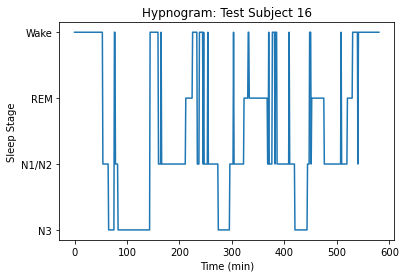

In [4]:
plt_idx = 0
mapping = {0:6, 5:4, 1:2, 3:0}
y_true = y_test[plt_idx][:seq_len_test[plt_idx]]
y_true = np.vectorize(mapping.get)(y_true)

plt.figure()
plt.plot(y_true)
plt.yticks(ticks=[0, 2, 4, 6], labels=['N3', 'N1/N2', 'REM', 'Wake'])
plt.ylabel('Sleep Stage')
plt.xlabel('Time (min)')
plt.title(f'Hypnogram: Test Subject {radar_dataset.user_test[plt_idx]}')
plt.show()

In [5]:
type_class, count_class = np.unique(y_train, return_counts=True)
type_class = type_class[:-1]
num_class = 7
count_class = count_class[:-1]

BATCH_SIZE = 4
n_hidden = [256, 256, 256]
num_steps = x_train.shape[1]  

print('Classes:', type_class)
print('Counts:', count_class)

Classes: [0. 1. 3. 5.]
Counts: [3497 6300 2580 2821]


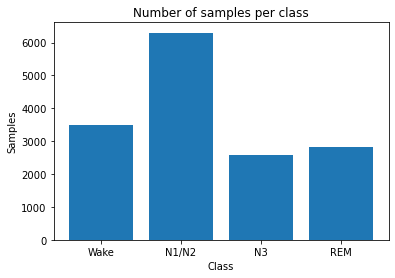

In [6]:
plt.figure()
plt.bar([0, 1, 2, 3], count_class)
plt.xticks(ticks=[0, 1, 2, 3], labels=['Wake', 'N1/N2', 'N3', 'REM'])
plt.ylabel('Samples')
plt.xlabel('Class')
plt.title('Number of samples per class')

plt.show()

#### LSTM Model

In [7]:
class Encoder(tf.keras.Model):
    def __init__(self, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units

        self.conv1 = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, 
                                            padding='same', trainable=True, use_bias=True, 
                                            bias_initializer=tf.keras.initializers.Constant(value=0.1))
        self.bn1 = tf.keras.layers.BatchNormalization(trainable=True, scale=True)
        self.relu1 = tf.keras.layers.ReLU()
        
        self.conv2 = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, 
                                            padding='same', trainable=True, use_bias=True,
                                            bias_initializer=tf.keras.initializers.Constant(value=0.1))
        self.bn2 = tf.keras.layers.BatchNormalization(trainable=True, scale=True)
        self.relu2 = tf.keras.layers.ReLU()

        self.conv3 = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1,
                                             padding='same', trainable=True, use_bias=True,
                                             bias_initializer=tf.keras.initializers.Constant(value=0.1))
        self.bn3 = tf.keras.layers.BatchNormalization(trainable=True, scale=True)
        self.relu3 = tf.keras.layers.ReLU()

        self.fc1 = tf.keras.layers.Dense(32, 
                                         kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4),
                                         bias_regularizer=tf.keras.regularizers.L2(1e-4),
                                         activity_regularizer=tf.keras.regularizers.L2(1e-5))
        self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.relu4 = tf.keras.layers.ReLU()

        self.lstm0 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units, return_sequences=True, return_state=True))
        self.lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units, return_sequences=True, return_state=True))
        self.lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units, return_sequences=True, return_state=True))
        self.lstm3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units, return_sequences=True, return_state=True))
        self.lstm4 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units, return_sequences=True, return_state=True))
        self.lstm5 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units, return_sequences=True, return_state=True))

        self.full_units = num_class
        self.fc2 = tf.keras.layers.Dense(self.full_units)
        self.dropout2 = tf.keras.layers.Dropout(0.3)

    def call(self, x, x_len, training=True):
        x = tf.reshape(x, [-1, x_train.shape[1], x_train.shape[2]])
        mask = tf.sequence_mask(x_len, x_train.shape[1])

        conv1 = self.conv1(x)
        bn1 = self.bn1(conv1)
        h_conv1 = self.relu1(bn1)

        conv2 = self.conv2(h_conv1)
        bn2 = self.bn2(conv2)
        h_conv2 = self.relu2(bn2)

        conv3 = self.conv3(h_conv2)
        bn3 = self.bn3(conv3)
        h_conv3 = self.relu3(bn3)

        h_conv = h_conv1 + h_conv2 + h_conv3
        h_conv_shape = h_conv.get_shape().as_list()
        xmotion = tf.reshape(h_conv, [-1, h_conv_shape[2]])

        fc1 = self.relu4(self.dropout1(self.fc1(xmotion)))
        fc1 = tf.reshape(fc1, [-1, x_train.shape[1], 32])

        lstm0 = self.lstm0(fc1, mask=mask)
        lstm1 = self.lstm1(lstm0[0], mask=mask, initial_state=lstm0[1:])
        lstm2 = self.lstm2(lstm1[0], mask=mask, initial_state=lstm1[1:])
        lstm3 = self.lstm3(lstm2[0], mask=mask, initial_state=lstm2[1:])
        lstm4 = self.lstm4(lstm3[0], mask=mask, initial_state=lstm3[1:])
        lstm5 = self.lstm5(lstm4[0], mask=mask, initial_state=lstm4[1:])

        lstm_sum = lstm2[0] + lstm3[0] + lstm4[0] + lstm5[0]
        outputs = tf.reshape(lstm_sum, [-1, n_hidden[-1] * 2])
        fc2 = self.dropout2(self.fc2(outputs))

        results = tf.reshape(fc2, [-1, num_steps, num_class])
        
        return results

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [8]:
encoder = Encoder(n_hidden[0], BATCH_SIZE)
optimizer = tf.keras.optimizers.Adam(amsgrad=True, learning_rate=0.001, decay=0.01)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [9]:

def loss_function(real, pred, inputs_len):
    cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = cross_entropy(y_true=real, y_pred=pred)
    mask = tf.logical_not(tf.math.equal(real, num_class-1))  # output 0 for y=0 else output 1
    mask = tf.cast(mask, dtype=loss.dtype)
    loss = mask * loss
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    sequence_mask = tf.sequence_mask(lengths=inputs_len, maxlen=max(radar_dataset.seq_lens), dtype=tf.float32)
    real = tf.convert_to_tensor(real, dtype=tf.int32)
    bb = tfa.seq2seq.sequence_loss(logits=pred, targets=real, weights=sequence_mask)
    return bb

def accuracy(real, pred):
    acc = tf.math.equal(pred, real)
    acc = tf.cast(acc, dtype=tf.float32)
    mask = tf.logical_not(tf.math.equal(real, num_class-1))  # output 0 for y=0 else output 1
    mask = tf.cast(mask, dtype=acc.dtype)

    acc = mask * acc
    acc = tf.reduce_sum(acc) / tf.reduce_sum(mask)
    return acc

def train_step(inp, targ, inp_len):
    with tf.GradientTape() as tape:
        results = encoder(inp, inp_len)
        real = targ
        loss = loss_function(real, results, inp_len)
        prediction = tf.argmax(results, -1, output_type=tf.int32, name='prediction')
        acc = accuracy(real, prediction)
    variables = encoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss, acc, optimizer.learning_rate

def test_step(inp, inp_len, targ):
    results = encoder(inp, inp_len, training=False)
    real = targ
    loss = loss_function(real, results, inp_len)
    prediction = tf.argmax(results, -1, output_type=tf.int32, name='prediction')
    acc = accuracy(real, prediction)
    return loss, acc

def test_step2(inp, inp_len):
    results = encoder(inp, inp_len, training=False)
    prediction = tf.argmax(results, -1, output_type=tf.int32, name='prediction')
    return tf.nn.softmax(results), prediction

def generate_batch(X, step, batch_size):
    start = (step * batch_size) % len(X)
    if start + batch_size >len(X):
        start = ((step + 1) * batch_size) % len(X)

    end = min(start + batch_size,len(X))
    batch_xs = X[start:end]
    return batch_xs # 生成每一个batch

In [10]:
def sleep_rule(pred, res):
    pred_new = [i for i in pred]
    for i in range(5):
        pred_new[i] = 0
    for i in range(5, len(pred_new)-3):
        if pred_new[i] in [3, 5] and pred_new[i-1] != pred_new[i]\
            and pred_new[i+1] != pred_new[i]:
            pred_new[i] = pred_new[i-1]
        if pred_new[i] in [3, 5] and pred_new[i] == pred_new[i+1] and pred_new[i-1] != pred_new[i]\
            and pred_new[i-2] != pred_new[i] and pred_new[i+2] != pred_new[i]\
            and pred_new[i+3] != pred_new[i]:
            pred_new[i] = pred_new[i-1]
            pred_new[i+1] = pred_new[i-1]
        if pred_new[i] in [3, 5] and pred_new[i] == pred_new[i+1] and  pred_new[i] == pred_new[i-1] and pred_new[i-2] != pred_new[i]\
            and pred_new[i+2] != pred_new[i]:
            pred_new[i] = pred_new[i-2]
            pred_new[i - 1] = pred_new[i - 2]
            pred_new[i + 1] = pred_new[i-2]
        if pred_new[i] in [3, 5] and pred_new[i+1] == pred_new[i] and pred_new[i-1] == pred_new[i-2] and pred_new[i-1] in [3, 5]\
                and pred_new[i-1] != pred_new[i]:
            pred_new[i] = 1
    pred_new = np.array(pred_new)
    correct_flag = 0
    for i in range(len(pred)):
        if pred[i] != pred_new[i]:
            correct_flag = 1
            break
    pred_new[-1] = 0
    return pred_new, correct_flag

#### Training

In [11]:
step = 0
epoch = 0
best_step = 0
best_acc = 0

step_train_loss_list = []
step_train_acc_list = []

In [12]:
print('---------- Training ----------')
while step < 10000:
    batch_x_train = generate_batch(x_train, step, BATCH_SIZE)
    batch_y_train = generate_batch(y_train, step, BATCH_SIZE)
    batch_seq_len_train = generate_batch(seq_len_train, step, BATCH_SIZE)
    step_train_loss, step_train_acc, lr = train_step(batch_x_train, batch_y_train, batch_seq_len_train)
    step_train_loss = tf.keras.backend.eval(step_train_loss); step_train_acc = tf.keras.backend.eval(step_train_acc)
    lr = tf.keras.backend.get_value(lr)
    step_train_loss_list.append(step_train_loss); step_train_acc_list.append(step_train_acc)

    print(f'Step {step} ---- Training Loss: {step_train_loss}, Training Accuracy: {step_train_acc}')

    # Reached one epoch
    if step % 7 == 0:
        train_loss = np.mean(step_train_loss_list); train_acc = np.mean(step_train_acc_list)
        step_train_loss_list = []; step_train_acc_list = []        
        val_loss, val_acc = test_step(x_test, seq_len_test, y_test)
        val_loss = tf.keras.backend.eval(val_loss); val_acc = tf.keras.backend.eval(val_acc)

        # Calculate precision, recall, fscore, cohen's kappa
        precision_list = []
        recall_list = []
        fscore_list = []
        cks_list = []
        y_res, y_pred = test_step2(x_test, seq_len_test)
        for i in range(len(x_test)):
            res = y_res[i].numpy()
            pred = y_pred[i]
            pred = pred.numpy()
            pred = pred[:seq_len_test[i]]
            y_pred_sleep_rule, correct_flag = sleep_rule(pred, res)
            y_true = y_test[i]
            y_true = y_true[:seq_len_test[i]]
            precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_true=y_true, y_pred=y_pred_sleep_rule)
            cks = metrics.cohen_kappa_score(y1=y_true, y2=y_pred_sleep_rule)
            
            precision_list.append(precision)
            recall_list.append(recall)
            fscore_list.append(fscore)
            cks_list.append(cks)

        precision, recall, fscore, cks = map(lambda x: np.array(x, dtype=np.float64), [precision_list, recall_list, fscore_list, cks_list])
        precision, recall, fscore, cks = map(lambda x: np.sum(x, axis=0) / len(x_test), [precision, recall, fscore, cks])

        # Save history
        with open('hist.csv', 'a', newline='') as f_object:
            writer_object = writer(f_object)
            writer_object.writerow([epoch, lr, train_loss, train_acc, val_loss, val_acc, precision, recall, fscore, cks])
            f_object.close()
        
        # Save model weights
        if val_acc >= best_acc and step >= 10:
            best_acc = val_acc
            best_step = step
            encoder.save_weights(f'./model/model_{step}_{np.round(train_acc, 4)}_{np.round(val_acc, 4)}.h5')

        print(f'Step {step} ----- Validation Loss: {val_loss}, Validation Accuracy: {val_acc} -----')
        epoch += 1
    
    elif step % 200 == 0:
        print(f'----- Best Accuracy: {best_acc}, Best Step:{best_step} -----')
        
    step += 1

---------- Training ----------


KeyboardInterrupt: 

#### Testing

---------- Testing ----------
Testing Sequence Length: [581 521 625]
Testing Accuracy: 0.6850029


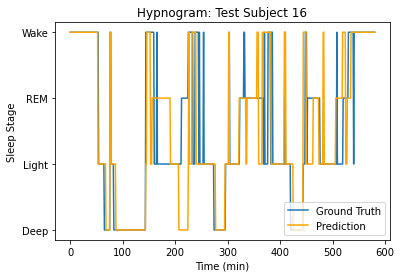

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       118
           2       0.69      0.67      0.68       215
           4       0.43      0.47      0.45        90
           6       0.78      0.77      0.77       158

    accuracy                           0.70       581
   macro avg       0.69      0.69      0.69       581
weighted avg       0.71      0.70      0.70       581

Cohen's Kappa Score: 0.5903631643511255


<Figure size 432x288 with 0 Axes>

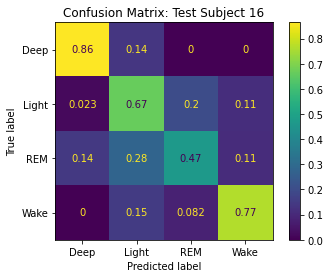

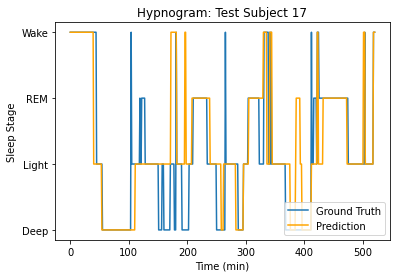

              precision    recall  f1-score   support

           0       0.88      0.58      0.70       149
           2       0.67      0.82      0.73       201
           4       0.80      0.79      0.79       105
           6       0.77      0.82      0.79        66

    accuracy                           0.75       521
   macro avg       0.78      0.75      0.76       521
weighted avg       0.77      0.75      0.74       521

Cohen's Kappa Score: 0.6405055880231257


<Figure size 432x288 with 0 Axes>

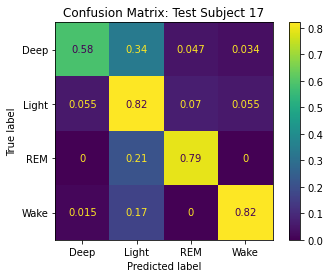

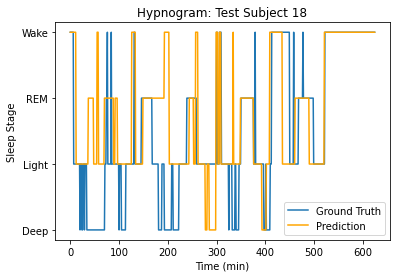

              precision    recall  f1-score   support

           0       0.15      0.04      0.06       110
           2       0.60      0.65      0.63       255
           4       0.53      0.77      0.63       100
           6       0.79      0.87      0.83       160

    accuracy                           0.62       625
   macro avg       0.52      0.58      0.54       625
weighted avg       0.56      0.62      0.58       625

Cohen's Kappa Score: 0.457522656406703


<Figure size 432x288 with 0 Axes>

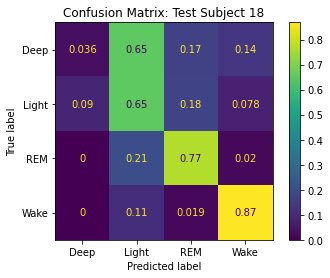

In [ ]:
print('---------- Testing ----------')
pred1 = test_step2(x_test, seq_len_test)
encoder.load_weights('./results/model1/model_539_0.9039999842643738_0.6850000023841858.h5')

test_loss, test_acc = test_step(x_test, seq_len_test, y_test)
print('Testing Sequence Length:', seq_len_test)
print('Testing Accuracy:', tf.keras.backend.eval(test_acc))

y_res, y_pred = test_step2(x_test, seq_len_test)

for i in range(len(x_test)):
    id = radar_dataset.user_test[i]
    res = np.array(y_res[i])
    pred = y_pred[i]
    pred = np.array(pred)
    pred = pred[:seq_len_test[i]]
    y_pred_sleep_rule, correct_flag = sleep_rule(pred, res)
    y_true = y_test[i]
    y_true = y_true[:seq_len_test[i]]
    sleep_stages = ['Deep', 'Light', 'REM', 'Wake']
    
    mapping = {0:6, 5:4, 1:2, 3:0}
    y_true = np.vectorize(mapping.get)(y_true)
    y_pred_sleep_rule = np.vectorize(mapping.get)(y_pred_sleep_rule)

    # Plot prediction results
    plt.figure()
    plt.yticks(ticks=[0, 2, 4, 6], labels=sleep_stages)
    plt.plot(y_true, label='Ground Truth')
    plt.legend(loc='lower right')
    plt.xlabel('Time (min)')
    plt.ylabel('Sleep Stage')
    plt.title(f'Hypnogram: Test Subject {id}')
    # plt.show()
    # plt.figure()
    plt.yticks(ticks=[0, 2, 4, 6], labels=sleep_stages)
    plt.plot(y_pred_sleep_rule, label='Prediction', color='orange')
    plt.legend(loc='lower right')
    plt.xlabel('Time (min)')
    plt.ylabel('Sleep Stage')
    # plt.title(f'Hypnogram: Test Subject {id}')
    plt.show()   

    # Confusion Matrix
    plt.figure()
    cm = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred_sleep_rule, labels=[0, 2, 4, 6])
    cm = cm / np.sum(cm, axis=1)[:, None]
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sleep_stages)
    disp.plot()
    plt.plot()
    plt.title(f'Confusion Matrix: Test Subject {id}')

    # Classification Report
    cr = metrics.classification_report(y_true=y_true, y_pred=y_pred_sleep_rule, labels=[0, 2, 4, 6])
    print(cr)

    # Cohen's Kappa Score
    cohen_kappa_score = metrics.cohen_kappa_score(y1=y_true, y2=y_pred_sleep_rule)
    print('Cohen\'s Kappa Score:', cohen_kappa_score)

    # ROC - AUC
    
    # Save prediction results
    # pred_array = [y_pred_sleep_rule, y_true, x_test[i], radar_dataset.x_test[i], res]
    # print(len(pred_new), len(yt), len(x_test[i]), len(radar_dataset.x_test[i]), len(res))
    # pred_array = np.array(pred_array)
    # np.savez_compressed(
    #     './data/bioradar/result/pred18',
    #     datapre=pred_array)